# Setup

### Import

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import json_normalize
import json
import os
import seaborn as sn

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Discover

Remove:
- id
- imdb_id
- original_title
- overview
- poster_path
- tagline
- title
- Keywords?
- genres?
- release_date

In [3]:
train = pd.read_csv('/content/drive/MyDrive/Machine Learning/ML datasets/tmdb_movie_data/train.csv')
train = train.drop(['imdb_id', 'original_title', 'overview', 'poster_path', 'tagline', 'title', 'Keywords'], axis=1)

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3000 non-null   int64  
 1   belongs_to_collection  604 non-null    object 
 2   budget                 3000 non-null   int64  
 3   genres                 2993 non-null   object 
 4   homepage               946 non-null    object 
 5   original_language      3000 non-null   object 
 6   popularity             3000 non-null   float64
 7   production_companies   2844 non-null   object 
 8   production_countries   2945 non-null   object 
 9   release_date           3000 non-null   object 
 10  runtime                2998 non-null   float64
 11  spoken_languages       2980 non-null   object 
 12  status                 3000 non-null   object 
 13  cast                   2987 non-null   object 
 14  crew                   2984 non-null   object 
 15  reve

In [5]:
train.head(5)

,id,belongs_to_collection,budget,genres,homepage,original_language,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,status,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,en,6.575393,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,en,8.248895,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,en,64.299990,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,hi,3.174936,NaN,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,"[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,ko,1.148070,NaN,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


In [6]:
train.revenue.mean()

train.loc[2]

id                                                                       3
belongs_to_collection                                                  NaN
budget                                                             3300000
genres                                       [{'id': 18, 'name': 'Drama'}]
homepage                                 http://sonyclassics.com/whiplash/
original_language                                                       en
popularity                                                            64.3
production_companies     [{'name': 'Bold Films', 'id': 2266}, {'name': ...
production_countries     [{'iso_3166_1': 'US', 'name': 'United States o...
release_date                                                      10/10/14
runtime                                                                105
spoken_languages                  [{'iso_639_1': 'en', 'name': 'English'}]
status                                                            Released
cast                     

## Read data

In [7]:
data = pd.read_csv('/content/drive/MyDrive/Machine Learning/ML datasets/tmdb_movie_data/train.csv')

# Split to test and train set

Splitting the data into train and test set

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split

y = data['revenue']
X = data.drop('revenue', axis=1)

X_train, y_train, X_test, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_test.shape

train = data

'\ntrain.budget.replace(0,train.budget.mean,inplace=True)\n\ntrain[\'budget_cat\'] = pd.cut(train[\'budget\'],\n                         bins=[0.,3000000.,10000000.,50000000.,150000000.,np.inf],\n                         labels=[1,2,3,4,5])\n\nsplit = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)\nfor train_index, test_index in split.split(train, train[\'budget_cat\']):\n    strat_train_set = train.loc[train_index]\n    strat_test_set = train.loc[test_index]\n    \nstrat_test_set["budget_cat"].value_counts() / len(strat_test_set)\n'

# Feature engineering

## Features to numbers

Creating functions to convert all raw data from set into floats

### genres

Print all genres and genre count

In [9]:
def count_genres(df):
  genre_count = {}

  for i, data in enumerate(df['genres']):
    if data is not np.nan:
      genres = eval(data)
      for genre in genres:
        name = genre['name']
        if name in genre_count:
          genre_count[name] += 1
        else:
          genre_count[name] = 1

  for k, v in genre_count.items():
    print(k, v)

  print(len(genre_count))

Create column for each genre, create column for number of genres in a movie

In [10]:
def create_genre_cols(df):
  # is_genre = 0 or 1
  for row in df.itertuples():
    if pd.notnull(row.genres):
      n = np.array(eval(row.genres))
      df.loc[row.Index, 'num_genres'] = len(n)
      for instance in n:
        genre_col = 'is_' + instance['name'].replace(" ", "_").lower()
        df.loc[row.Index, genre_col] = 1
    else:
      df.loc[row.Index, 'num_genres'] = 0

  # Set all is_genre with value NaN to 0
  for i, row in df.iterrows():
    for col in df.columns.values:
      if 'is' in col:
        if 'nan' in str(row[col]):
          df.loc[i, col] = 0

  return df


### is_tv_movie

Deleting is_tv_movie col since there is only 1 movie with that genre. Then train and test set get the same amount of columns.

In [11]:
def is_tv_movie_exists(df):
  return 'is_tv_movie' in list(df)

### belongs_to_collection & homepage

In [12]:
def has_value(col):
  values = []
  for i, data in enumerate(col):
    if data is not np.nan:
      values.append(1)
    else:
      values.append(0)
  return values


### original_language

In [13]:
from sklearn.preprocessing import OrdinalEncoder

def enc_original_language(df):
  enc = OrdinalEncoder()
  df['original_language'] = enc.fit_transform(df[['original_language']])
  return df


### production_companies

Changing the array of production companies to the lowest id. The well known companies generally have lowest ids.

In [14]:
def get_lowest_company_id(df):
  label = 'production_companies'

  for row in df.itertuples():
    col = row.production_companies
    if pd.notnull(row.production_companies):
      n = np.array(eval(col))
      ids = np.array([])
      for instance in n:
        json_id = ""
        for json_key in instance:
          if "id" in json_key:
            json_id = json_key
        ids = np.append(ids, instance[json_id])
      df.loc[row.Index, label] = ids.min()
  return df


### production_coutries

Check occurences of production countries

In [15]:
lang_count = {}

for i, row in enumerate(data['production_countries']):
  if row is not np.nan:
    languages = eval(row)
    for lang in languages:
      name = lang['iso_3166_1']
      if name in lang_count:
        lang_count[name] += 1
      else:
        lang_count[name] = 1

for k, v in lang_count.items():
  print(k, v)

print(len(lang_count))

US 2282
IN 81
KR 22
CA 120
RS 2
GB 380
AT 8
DE 167
FR 222
NZ 17
JP 61
IE 23
IT 64
IL 5
BE 23
CZ 14
CN 42
BR 12
AR 6
CL 6
PE 1
HK 42
RU 58
ES 54
TR 5
AU 61
SE 18
LU 10
ZA 10
CH 8
IR 5
MA 3
NL 15
PH 3
IS 2
DK 13
TW 3
MN 1
HU 9
MX 19
RO 8
GR 7
AE 9
PR 1
FI 6
KH 2
NO 7
PL 5
MT 2
NA 1
BA 1
CS 1
PK 2
DZ 1
ET 1
QA 2
TN 2
PT 1
BG 3
SI 1
UA 2
SA 1
JO 1
HR 1
SG 2
CY 1
UY 1
PY 1
MR 1
CR 1
BS 3
BF 1
GH 1
ID 2
74


How many prod countries for each movie

In [16]:
def count_prod_countries(df):
  label = 'production_countries'

  for row in df.itertuples():
    if pd.notnull(row.production_countries):
      num_prod_countries = eval(row.production_countries)
      df.loc[row.Index, 'num_prod_countries'] = len(num_prod_countries)
  return df

#train.groupby(['num_prod_countries']).count()

Create bool: Number of production countries more than 1

In [17]:
def prod_countries_over_1(df):
  for row in df.itertuples():
    col = row.num_prod_countries
    if pd.notnull(col):
      df.loc[row.Index, 'two_or_more_prod_countries'] = 1 if col > 1 else 0
  return df


### release_date

Convert release_date to month and year columns. First movie in the dataset is from 1921.


In [18]:
def convert_dates(df):  
  col = 'release_date'

  for row in df.itertuples():
    if pd.notnull(row.release_date):
      date = row.release_date.split('/')
      month = int(date[0])
      year = int(date[2])
      df.loc[row.Index, 'month'] = month
      df.loc[row.Index, 'year'] = 1900 + year if year > 20 else 2000 + year
  return df


### status

4 movies with status Rumored. Remove feature

In [19]:
'''for id, row in train.iterrows():
  if row['status'] not in "Released":
    print(row['status'])
    print(row)'''

'for id, row in train.iterrows():\n  if row[\'status\'] not in "Released":\n    print(row[\'status\'])\n    print(row)'

### cast

In [20]:
def cast_size_col(df):
  col = 'cast'

  for row in df.itertuples():
    if pd.notnull(row.cast):
      cast = eval(row.cast)
      df.loc[row.Index, 'cast_size'] = len(cast)
  return df


### crew

Crew size and director col

In [21]:
def crew_size_director_col(df):  
  label = 'crew'

  for row in df.itertuples():
    if pd.notnull(row.crew):
      crew_array = eval(row.crew)
      for instance in crew_array:
        if instance['job'] == 'Director':
          df.loc[row.Index, 'director'] = instance['id']
          break
      df.loc[row.Index, 'crew_size'] = len(crew_array)
  return df


### spoken_languages

Occurence of each language

In [22]:
lang_count = {}

for i, row in enumerate(data['spoken_languages']):
  if row is not np.nan:
    languages = eval(row)
    for lang in languages:
      name = lang['name']
      if name in lang_count:
        lang_count[name] += 1
      else:
        lang_count[name] = 1

for k, v in lang_count.items():
  print(k, v)

print(len(lang_count))

English 2618
हिन्दी 56
한국어/조선말 37
العربية 40
Pусский 152
svenska 22
Srpski 4
Deutsch 169
Français 288
Italiano 124
日本語 89
עִבְרִית 15
Português 43
Latin 23
普通话 68
Español 239
Nederlands 10
广州话 / 廣州話 36
 47
Český 20
தமிழ் 27
తెలుగు 7
Polski 25
Türkçe 13
Magyar 24
ελληνικά 15
Gaeilge 3
فارسی 10
ภาษาไทย 22
Català 3
Dansk 13
বাংলা 3
қазақ 1
Afrikaans 4
ਪੰਜਾਬੀ 3
български език 2
Kiswahili 7
Norsk 7
No Language 7
suomi 6
اردو 8
shqip 2
Română 8
Bahasa indonesia 2
Tiếng Việt 10
Slovenčina 2
Український 6
Esperanto 2
euskera 2
isiZulu 2
Somali 3
Íslenska 3
Wolof 1
Eesti 1
پښتو 1
Hrvatski 2
56


Create bool: Spoken language is english

In [23]:
'''
def has_english_as_lang(df):
  for i, data in enumerate(df['spoken_languages']):
    if data is not np.nan:
      languages = eval(data)
      for lang in languages:
        lang = lang['iso_639_1']
        if lang in 'en':
          df.loc[i, 'english_spoken'] = 1
          break
        df.loc[i, 'english_spoken'] = 0
  return df
'''

def has_english_as_lang(df):
  for row in df.itertuples():
    if pd.notnull(row.spoken_languages):
      languages = eval(row.spoken_languages)
      for lang in languages:
        lang = lang['iso_639_1']
        if lang in 'en':
          df.loc[row.Index, 'english_spoken'] = 1
          break
        df.loc[row.Index, 'english_spoken'] = 0
  return df

### Keywords

Number of keywords

In [24]:
def count_keywords(df):
  for row in df.itertuples():
    col = row.Keywords
    df.loc[row.Index, 'num_keywords'] = len(eval(col)) if pd.notnull(col) else 0
  return df


### budget and revenue log transformation

In [25]:
def log_transformation_col(col):
  return np.log1p(col)

### revenue

#### Comparing revenue difference for movies with budget and movies without budget

In [26]:
df = pd.read_csv('/content/drive/MyDrive/Machine Learning/ML datasets/tmdb_movie_data/train.csv')

total_budget = 0
total_no_budget = 0

count_budget = 0
count_no_budget = 0

# Count movies with and without/not given budgets and their revenue
for id, movie in df.iterrows():
  if movie['budget'] is not 0:
    count_budget += 1
    total_budget += movie['revenue']
  else:
    count_no_budget += 1
    total_no_budget += movie['revenue']


avg_budget = total_budget / count_budget
avg_no_budget = total_no_budget / count_no_budget

print("Movies with budget:    ", count_budget)
print("Movies without budget: ", count_no_budget)

print("Average revenue for movies with budget:    ", int(avg_budget))
print("Average revenue for movues without budget: ", int(avg_no_budget))

Movies with budget:     2188
Movies without budget:  812
Average revenue for movies with budget:     86966045
Average revenue for movues without budget:  12187006


A lot of movies with budget 0. We assume most of them have a budget, but not given.

## Remove features

In [27]:
#def remove_non_relavant_features(df):
#  return df.drop(['id', 'imdb_id', 'original_title', 'overview', 'poster_path', 'tagline', 'title', 'status', 'genres', 'production_countries', 'release_date', 'cast', 'crew', 'spoken_languages', 'Keywords'], axis=1)

features_to_be_removed_first = ['imdb_id', 'original_title', 'overview', 'poster_path', 'tagline', 'title', 'status']
features_to_be_removed_last = ['id', 'genres', 'production_countries', 'release_date', 'cast', 'crew', 'spoken_languages', 'Keywords']


## Combining features

In [28]:
def combine_selected_features(df):
  #df['crew_cast'] = df['crew_size'] / df['cast_size'] # gives error
  df['family_animation'] = df['is_family'] * df['is_animation']
  return df


## Print

In [29]:
train.head(10)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,NaN,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,NaN,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970
5,6,NaN,8000000,"[{'id': 16, 'name': 'Animation'}, {'id': 12, '...",NaN,tt0093743,en,Pinocchio and the Emperor of the Night,"Pinocchio and his friends, a glow worm and a m...",0.743274,/6IDqA1D2NBIVhzEEaMMRL28iBrq.jpg,NaN,NaN,8/6/87,83.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Pinocchio and the Emperor of the Night,NaN,"[{'cast_id': 6, 'character': 'Pinocchio (voice...","[{'credit_id': '52fe46f49251416c9106558b', 'de...",3261638
6,7,NaN,14000000,"[{'id': 27, 'name': 'Horror'}, {'id': 53, 'nam...",http://www.thepossessionmovie.com/,tt0431021,en,The Possession,A young girl buys an antique box at a yard sal...,7.286477,/4QjzFuaZmB4btGnLwAgdp23BzIU.jpg,"[{'name': 'Ghost House Pictures', 'id': 768}, ...","[{'iso_3166_1': 'US', 'name': 'United States o...",8/30/12,92.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Fear The Demon That Doesn't Fear God,The Possession,NaN,"[{'c

## Null-values

# Test Feature Engineering Functions

Testing the feature functions on dataset. Using the same (data_set) for plots and correlations later

In [30]:
data_set = data

data_set = data_set.drop(features_to_be_removed_first, axis=1)
data_set = create_genre_cols(data_set)
data_set['homepage'] = has_value(data_set['homepage'])
data_set['belongs_to_collection'] = has_value(data_set['belongs_to_collection'])
data_set = enc_original_language(data_set)
data_set = get_lowest_company_id(data_set)
data_set = count_prod_countries(data_set)
data_set = prod_countries_over_1(data_set)
data_set = convert_dates(data_set)
data_set = cast_size_col(data_set)
data_set = crew_size_director_col(data_set)
data_set = has_english_as_lang(data_set)
data_set = count_keywords(data_set)
data_set = combine_selected_features(data_set)
data_set = data_set.drop(features_to_be_removed_last, axis=1)

#data_set['budget'] = log_transformation_col(data_set['budget'])
#data_set['revenue'] = log_transformation_col(data_set['revenue'])

In [31]:
X_train.head(5)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew
642,643,NaN,39000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",NaN,tt0094898,en,Coming to America,"Prince Akeem, heir to the throne of Zamunda, l...",7.830087,/7v1Sy0HC5KEM1DMM4Bpy5gVly1K.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",6/28/88,116.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Four Funniest Men in America are Eddie Mur...,Coming to America,"[{'id': 3015, 'name': 'fast food restaurant'},...","[{'cast_id': 1, 'character': 'Prince Akeem / C...","[{'credit_id': '52fe450fc3a36847f80ba1d3', 'de..."
700,701,NaN,25000000,"[{'id': 27, 'name': 'Horror'}, {'id': 35, 'nam...",NaN,tt0091419,en,Little Shop of Horrors,Seymour Krelborn is a nerdy orphan working at ...,7.409179,/bxRm8F7rnCsVDyrNh3K9yIFFBKL.jpg,"[{'name': 'The Geffen Company', 'id': 2956}, {...","[{'iso_3166_1': 'US', 'name': 'United States o...",12/19/86,94.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Don't feed the plants.,Little Shop of Horrors,"[{'id': 2382, 'name': 'flower'}, {'id': 2642, ...","[{'cast_id': 8, 'character': 'Seymour Krelborn...","[{'credit_id': '52fe43b59251416c7501b029', 'de..."
226,227,NaN,50000000,"[{'id': 14, 'name': 'Fantasy'}, {'id': 53, 'na...",http://www.driveangry3d.com/,tt1502404,en,Drive Angry,Milton is a hardened felon who has broken out ...,7.668829,/afYwV0EAO8YLRyrTnNaSRysDrCh.jpg,"[{'name': 'Summit Entertainment', 'id': 491}, ...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/24/11,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,One hell of a ride.,Drive Angry,"[{'id': 4479, 'name': 'bone'}, {'id': 41019, '...","[{'cast_id': 4, 'character': 'Milton', 'credit...","[{'credit_id': '54e07d43c3a368454d0053e5', 'de..."
1697,1698,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,tt0105391,en,Shining Through,Spirited New Yorker Linda Voss goes to work fo...,5.860319,/e3D4a0B7BbzJfDMuLurDvxZP2oY.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",1/31/92,132.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,He needed to trust her with his secret. She ha...,Shining Through,"[{'id': 74, 'name': 'germany'}, {'id': 818, 'n...","[{'cast_id': 2, 'character': 'Ed Leland', 'cre...","[{'credit_id': '58fd30ef925141643c02713f', 'de..."
1010,1011,NaN,35000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt3152624,en,Trainwreck,Having thought that monogamy was never possibl...,17.310647,/2USk7mhiCXRkU9NzttXCzOjg2iV.jpg,"[{'name': 'Universal Pictures', 'id': 33}, {'n...","[{'iso_3166_1': 'US', 'name': 'United States o...",7/17/15,125.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,We All Know One.,Trainwreck,"[{'id': 567, 'name': 'alcohol'}, {'id': 2864, ...","[{'cast_id': 4, 'character': 'Amy Townsend', '...","[{'credit_id': '55aa7f0c92514172ef003b26', 'de..."


# Plots

### Histograms

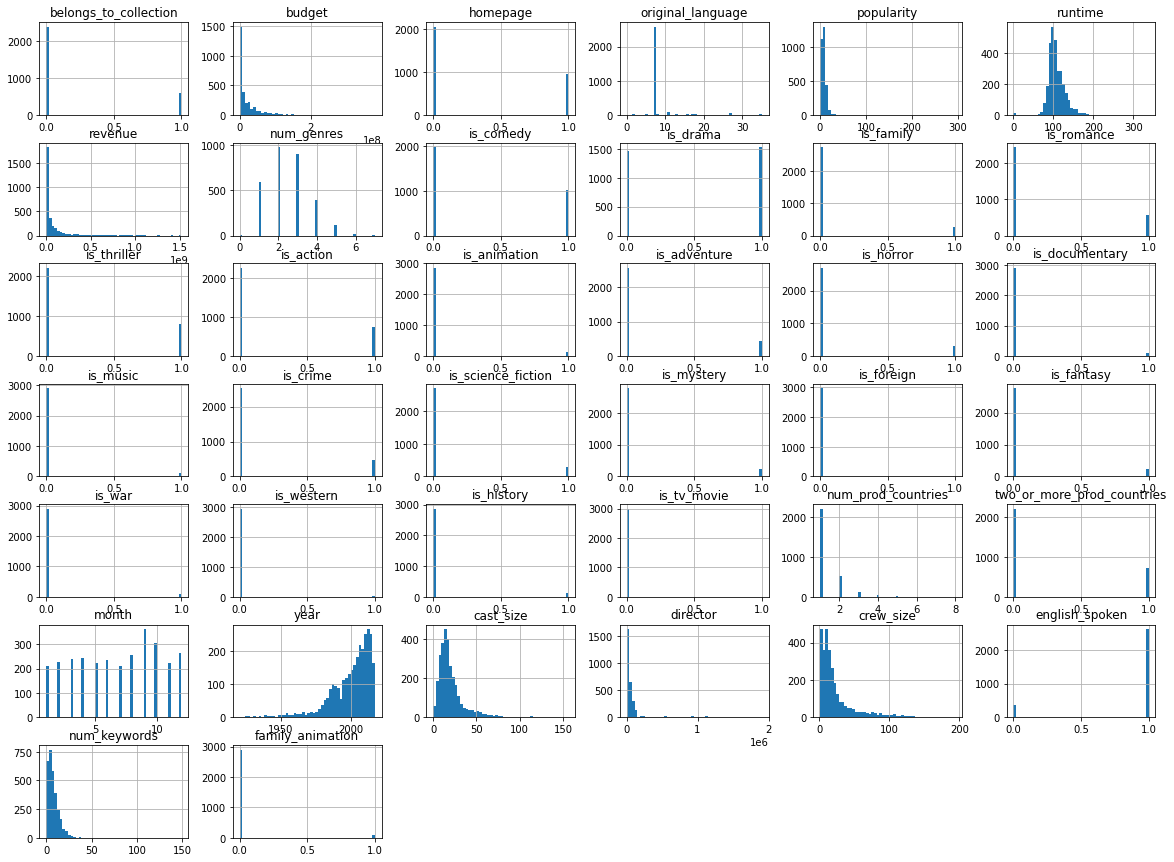

In [32]:
data_set.hist(bins=50, figsize=(20,15))
plt.show()

### Budget and Revenue

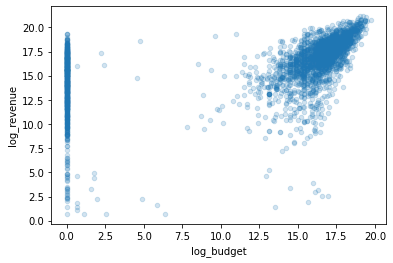

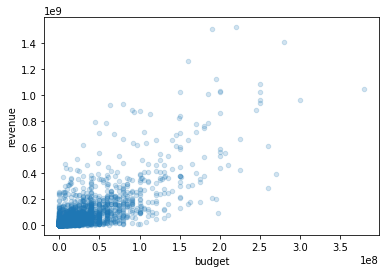

In [33]:
plot_df = pd.DataFrame()
plot_df['log_budget'] = log_transformation_col(data['budget'])
plot_df['log_revenue'] = log_transformation_col(data['revenue'])


plot_df.plot(kind='scatter', x='log_budget', y='log_revenue', alpha=0.2)
data.plot(kind='scatter', x='budget', y='revenue', alpha=0.2)
plt.show()

Getting a nicer distribution of bugdet with np.log1p.

### Release and Revenue

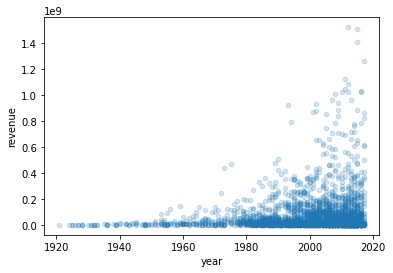

In [34]:
data_set.plot(kind='scatter', x='year', y='revenue', alpha=0.2)
plt.show()

### Cast size and Revenue

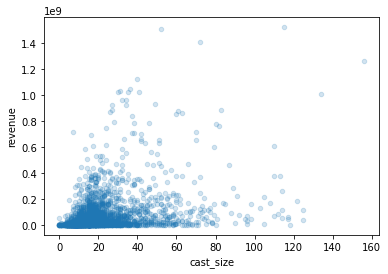

In [35]:
data_set.plot(kind='scatter', x='cast_size', y='revenue', alpha=0.2)
plt.show()

## Crew size and Revenue

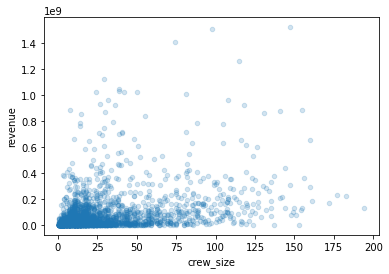

In [36]:
data_set.plot(kind='scatter', x='crew_size', y='revenue', alpha=0.2)
plt.show()

## Popularity and Revenue

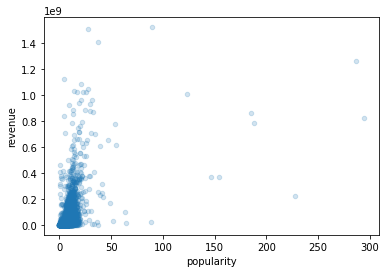

In [37]:
data_set.plot(kind='scatter', x='popularity', y='revenue', alpha=0.2)
plt.show()

## Revenue

<Figure size 864x864 with 0 Axes>

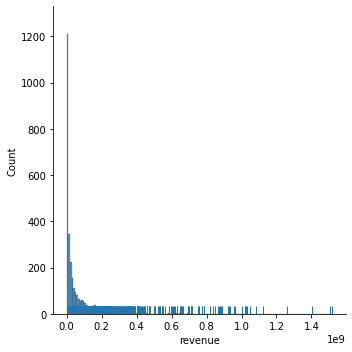

In [38]:
plt.figure(figsize=(12,12))
sn.displot(train['revenue'],rug=True)

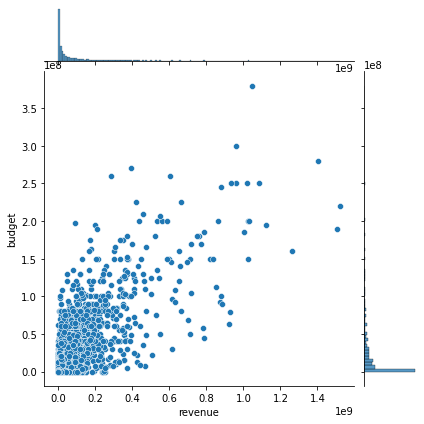

In [39]:
sn.jointplot(x='revenue', y='budget', data=train)

# Correlations

In [40]:
data_set['revenue'] = log_transformation_col(data_set['revenue'])
data_set['budget'] = log_transformation_col(data_set['budget'])
corr_matrix = data_set.corr()
corr_matrix["revenue"].sort_values(ascending=False)

revenue                       1.000000
budget                        0.498184
crew_size                     0.345627
cast_size                     0.307218
popularity                    0.288506
belongs_to_collection         0.256553
num_keywords                  0.234985
is_adventure                  0.218680
english_spoken                0.216379
runtime                       0.210098
num_genres                    0.190505
is_action                     0.166816
homepage                      0.143133
is_family                     0.135969
is_fantasy                    0.123553
family_animation              0.109779
is_science_fiction            0.100467
is_animation                  0.084932
is_thriller                   0.062887
is_crime                      0.046424
is_mystery                    0.039537
two_or_more_prod_countries    0.039261
year                          0.034943
month                         0.031051
is_comedy                     0.029877
num_prod_countries       

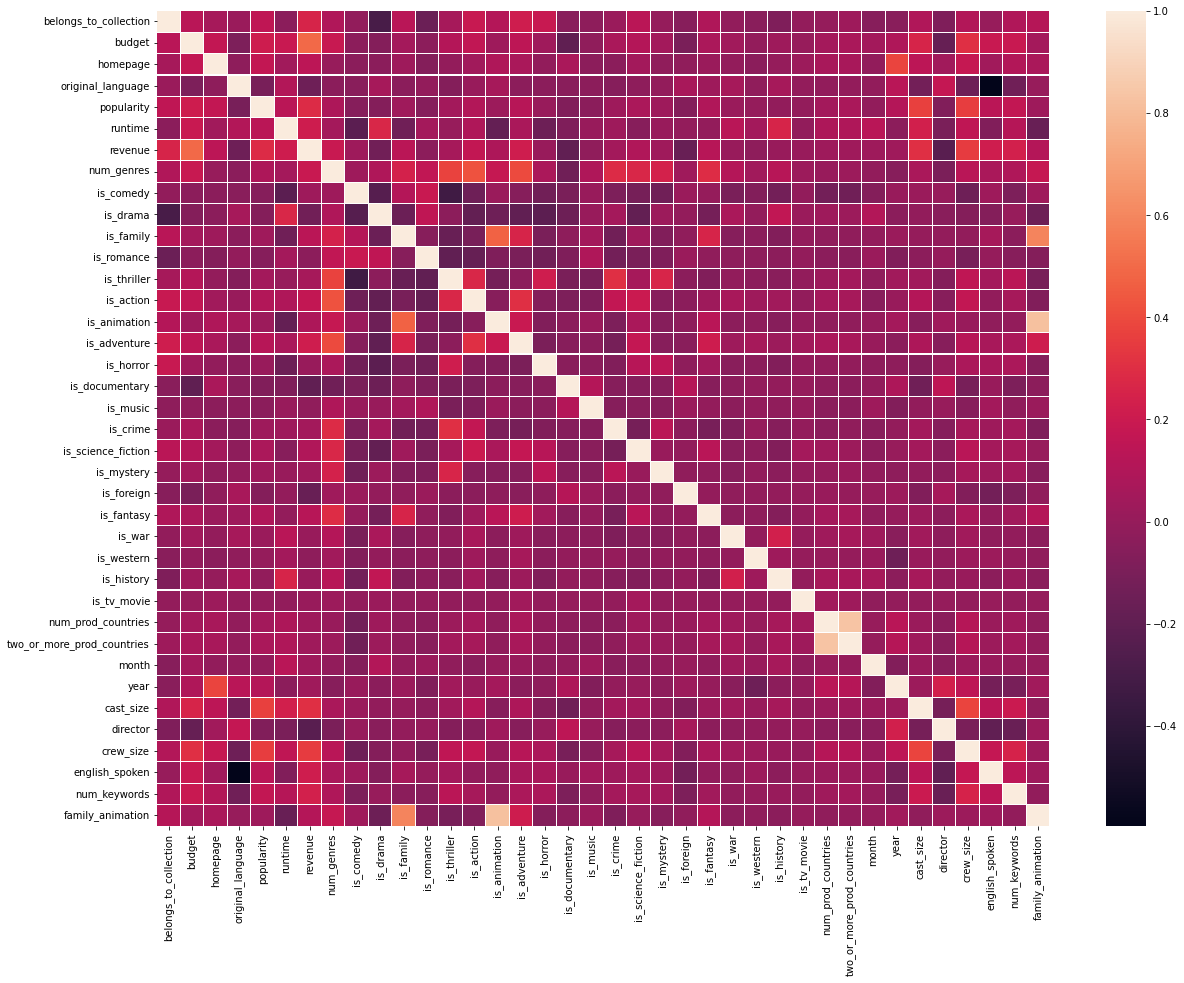

In [41]:
plt.subplots(figsize=(20,15))
sn.heatmap(corr_matrix, annot=False, linewidths=0.1)

Animation and family movies related

In [42]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3000 non-null   int64  
 1   belongs_to_collection  604 non-null    object 
 2   budget                 3000 non-null   int64  
 3   genres                 2993 non-null   object 
 4   homepage               946 non-null    object 
 5   imdb_id                3000 non-null   object 
 6   original_language      3000 non-null   object 
 7   original_title         3000 non-null   object 
 8   overview               2992 non-null   object 
 9   popularity             3000 non-null   float64
 10  poster_path            2999 non-null   object 
 11  production_companies   2844 non-null   object 
 12  production_countries   2945 non-null   object 
 13  release_date           3000 non-null   object 
 14  runtime                2998 non-null   float64
 15  spok

# Pipeline

### Selected features

Features to use i training data set

In [43]:
selected_features = ['budget', 'popularity', 'crew_size', 'cast_size', 'belongs_to_collection', 'is_adventure', 'homepage', 'runtime', 'num_genres', 'is_action', 'english_spoken', 'num_keywords', 'director']
#selected_features = ['budget', 'popularity', 'cast_size', 'director']

### Define pipeline

In [44]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin

features = []

class FeaturesToNumbers(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X):
        return self
    def transform(self, X):
        X = create_genre_cols(X)
        if is_tv_movie_exists(X):
          X = X.drop('is_tv_movie', axis=1)
        X['belongs_to_collection'] = has_value(X['belongs_to_collection'])
        X['homepage'] = has_value(X['homepage'])
        X = enc_original_language(X)
        X = get_lowest_company_id(X)
        X = count_prod_countries(X)
        X = prod_countries_over_1(X)
        X = convert_dates(X)
        X = cast_size_col(X)
        X = crew_size_director_col(X)
        X = has_english_as_lang(X)
        X = count_keywords(X)

        # Log transform
        X['budget'] = log_transformation_col(X['budget'])
        X['popularity'] = log_transformation_col(X['popularity'])
        X['crew_size'] = log_transformation_col(X['crew_size'])
        X['cast_size'] = log_transformation_col(X['cast_size'])

        X = X.drop(features_to_be_removed_last, axis=1)
        X = combine_selected_features(X)
        X = X.filter(items=selected_features)
        return X


num_pipeline = Pipeline([
            ('feature_num', FeaturesToNumbers()),
            ('imputer', SimpleImputer(strategy="median")),
            ('std_scaler', StandardScaler()),
        ])

full_pipeline = ColumnTransformer([
             ("num", num_pipeline, list(X_train.drop(features_to_be_removed_first, axis=1))),
             #("cat", OrdinalEncoder(), []),
         ])

### Select features to use and prepare for training.

Prepare train set

In [45]:
#train_prep = train.filter(items=['budget', 'popularity', 'crew_size', 'cast_size', 'belongs_to_collection', 'is_adventure', 'homepage'])
train_prep = X_train.drop(features_to_be_removed_first, axis=1)
train_prep = full_pipeline.fit_transform(train_prep)
train_prep.shape

(2400, 13)

Prepare test set

In [46]:
test_prep = y_train.drop(features_to_be_removed_first, axis=1)
test_prep = full_pipeline.fit_transform(test_prep)
test_prep.shape

(600, 13)

Log transform revenue columns used for training and testing

In [47]:
X_test = log_transformation_col(X_test)
y_test = log_transformation_col(y_test)

# Training

In [48]:
print(train_prep.shape)
print(test_prep.shape)
print(X_test.shape)
print(y_test.shape)

(2400, 13)
(600, 13)
(2400,)
(600,)


## Linear Regression

In [49]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
linear_model = lin_reg.fit(train_prep, X_test)

In [50]:
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error

y_pred = linear_model.predict(test_prep)

lin_msle = mean_squared_error(y_test, y_pred)
lin_rmsle = np.sqrt(lin_msle)
lin_rmsle

2.2287240013846383

## Random Forest

#### Old

In [51]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=500, max_features=4, random_state=42)
forest_model = forest_reg.fit(train_prep, X_test)

Root mean squared log error: 0.19331064494127098
Root mean squared error:     2.198343350895858


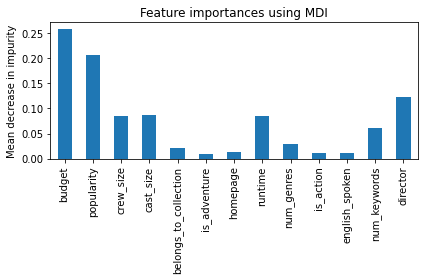

In [52]:
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error

y_pred = forest_model.predict(test_prep)

lin_msle = mean_squared_log_error(y_test, y_pred)
lin_rmsle = np.sqrt(lin_msle)
print("Root mean squared log error:", lin_rmsle)

lin_mse = mean_squared_error(y_test, y_pred)
lin_rmse = np.sqrt(lin_mse)
print("Root mean squared error:    ", lin_rmse)

importances = forest_model.feature_importances_
forest_importances = pd.Series(importances, index=selected_features)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

#### New parameters (best result, used in web app)

In [53]:
rf_reg = RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt', min_samples_leaf=4, min_samples_split=2, n_estimators=500, random_state=42)
rf_model = rf_reg.fit(train_prep, X_test)

In [64]:
y_pred = rf_model.predict(test_prep)

error = mean_squared_error(y_test, y_pred)
root_error = np.sqrt(error)
print("Root mean squared log error: ", root_error)

Root mean squared log error:  2.1863159966362353


RFR giving the best results

Feature importances

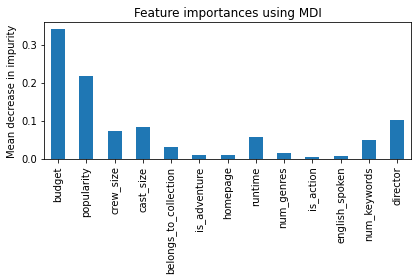

In [55]:
importances = rf_model.feature_importances_
forest_importances = pd.Series(importances, index=selected_features)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## XGB

In [59]:
import xgboost as xgb

params = {
    'objective': 'reg:squarederror',
    'eta': 0.01,
    'colsample_bytree': 0.4,
    'learning_rate': 0.01,
    'max_depth': 12,
    'alpha': 10,
    'n_estimators': 2500,
    'num_feature': 4
}

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.4, learning_rate = 0.01,
                max_depth = 12, alpha = 10, n_estimators = 2500, num_feature=4)

xg_model = xg_reg.fit(train_prep, X_test)

In [60]:
y_pred = xg_model.predict(test_prep)

error = mean_squared_error(y_test, y_pred)
root_error = np.sqrt(error)
print(root_error)

2.260113796340424


# Export model

In [61]:
import pickle

#pickle.dump(rf_model, open('rf_model_4.pkl', 'wb'))

Function used as pipeline in the web app

In [62]:
def pipeline_func(X):
  X['budget'] = np.log1p(X['budget'])
  X['popularity'] = np.log1p(X['popularity'])
  X['cast_size'] = np.log1p(X['cast_size'])

  scaler = StandardScaler()
  scaledX = scaler.fit_transform(X)

  return X